In [1]:
import numpy as np
from application.evaluation.metrics.iou import IoU
from PIL import Image
import matplotlib.pyplot as plt
import json

from application.evaluation.metrics.get_indexMap import get_indMap
from map.utils.matterport3d_categories import mp3dcat
from map.utils.mapping_utils import load_map
from application.evaluation.metrics.metrics import gt_idx_change, idxMap, SegmentationMetric

root_dir = !pwd
root_dir = root_dir[0]
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
# dataset_type = "ori_replica"
scene_id = "apartment_0_1"
data_dir = os.path.join(root_dir, "Data/habitat_sim/replica", scene_id) #vlmaps_dataset
vlns = ["lseg", "seem","ours"]
versions = ["lseg","seem","b1209_ps50aft_s"]#"test1227_params_bbox_conf09_psp20"]#"b1209_ps50aft_s"]

categories = ["mp3d", "ori_replica","replica", "new_replica"]


num = 2
use_hm3d = False
cat_num = 2
new_cat_num = 2

vln = vlns[num]
version = versions[num] #"b1209_ps50aft_s"
gt_version = "gt"

ori_categories = categories[cat_num] #"ori_replica"
convert_categories = categories[new_cat_num] #"ori_replica"

In [2]:
import csv
categories = "/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/simulation_dataset/HM3D_CountsOfObjectTypes.csv"
import pandas as pd
from map.utils.matterport3d_categories import mp3dcat
from map.utils.replica_categories import replica_cat, cat2id
from map.utils.replica_categories import new_cat as new_replica_cat

# CSV 파일 읽기
df = pd.read_csv(categories, sep=';')
print(df)
hm3d_cat = df['Object Type Name'].tolist()
print(len(hm3d_cat))
hm3d_cat4mp3d_cat = [item for item in hm3d_cat if item not in mp3dcat]

       Object Type Name   # of instances in semantic text files
0                  wall                                   25036
1               unknown                                    5970
2               picture                                    4471
3               ceiling                                    4440
4                pillow                                    3841
...                 ...                                     ...
1619       hi-hat stand                                       1
1620  sheet music stand                                       1
1621        bath hanger                                       1
1622             buffet                                       1
1623    kitchen ceiling                                       1

[1624 rows x 2 columns]
1624


In [3]:
gt_path = os.path.join(data_dir, "map/",f"{scene_id}_gt",f"grid_{gt_version}2.npy")
obstacle_path = os.path.join(data_dir,"map",f"{scene_id}_{version}",f"obstacles_{version}.npy")
color_top_down_path = os.path.join(data_dir,"map",f"{scene_id}_{version}",f"color_top_down_{version}.npy")
gt_map = load_map(gt_path)
obstacle_map = load_map(obstacle_path)
rgb_map = load_map(color_top_down_path)
print(gt_map.shape)

(2000, 2000)


804 1393 886 1259


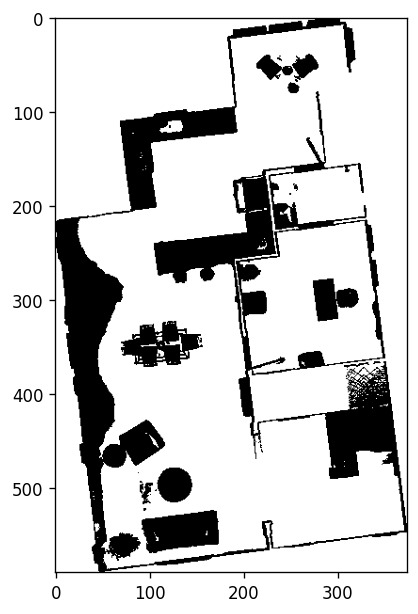

In [4]:
from map.utils.matterport3d_categories import mp3dcat
from map.utils.replica_categories import replica_cat, cat2id
if vln  == "ours":
    x_indices, y_indices = np.where(obstacle_map == 0)
else:
    x_indices, y_indices = np.where(obstacle_map == 1)
xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(xmin, xmax, ymin, ymax)
obstacles_pil = Image.fromarray(obstacle_map[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

gt_map = gt_map[xmin:xmax+1, ymin:ymax+1]

In [5]:
if ori_categories == "ori_replica":
    cat_path = os.path.join(data_dir, "map", f"semantic_info_{gt_version}.json")
    with open(cat_path) as f:
        categories = json.load(f)
    categories = categories 
elif ori_categories == "mp3d":
    categories = mp3dcat
elif ori_categories == "replica":
    categories = replica_cat
elif ori_categories == "new_replica":
    categories = new_replica_cat

if convert_categories == "ori_replica":
    cat_path = os.path.join(data_dir, "map", f"semantic_info_{gt_version}.json")
    with open(cat_path) as f:
        new_categories = json.load(f)
    hm3d_cat4replica = [item for item in hm3d_cat if item not in new_categories]
    if use_hm3d:
        new_categories = new_categories + hm3d_cat4replica
    print("# of categories: ", len(new_categories))
elif convert_categories == "mp3d":
    hm3d_cat4mp3d_cat = [item for item in hm3d_cat if item not in mp3dcat]
    if use_hm3d:
        new_categories = mp3dcat  + hm3d_cat4mp3d_cat
    else: new_categories = mp3dcat
    print("# of categories: ",len(new_categories))
elif convert_categories == "replica":
    hm3d_cat4replica = [item for item in mp3dcat if item not in replica_cat]
    if use_hm3d:
        new_categories = replica_cat + hm3d_cat4replica
    else:
        new_categories = list(replica_cat.values())
    print("# of categories: ",len(new_categories))
elif convert_categories == "new_replica":
    hm3d_cat4replica = [item for item in mp3dcat if item not in new_replica_cat]
    if use_hm3d:
        new_categories = new_replica_cat + hm3d_cat4replica
    else:
        new_categories = list(new_replica_cat.values())
    print("# of categories: ",len(new_categories))

# gt_map = gt_idx_change(gt_map, categories, new_categories)

# of categories:  102


In [6]:
index_map = idxMap(vln, new_categories, (xmin,xmax,ymin,ymax), scene_id, version, data_dir)

[*] model loaded


In [7]:
print(f"# of instances : {len(index_map.sorted_idx_dict)}")
print(index_map.idx_map.shape)
gt_map = gt_map.astype(np.int32)

# of instances : 107
(590, 374)


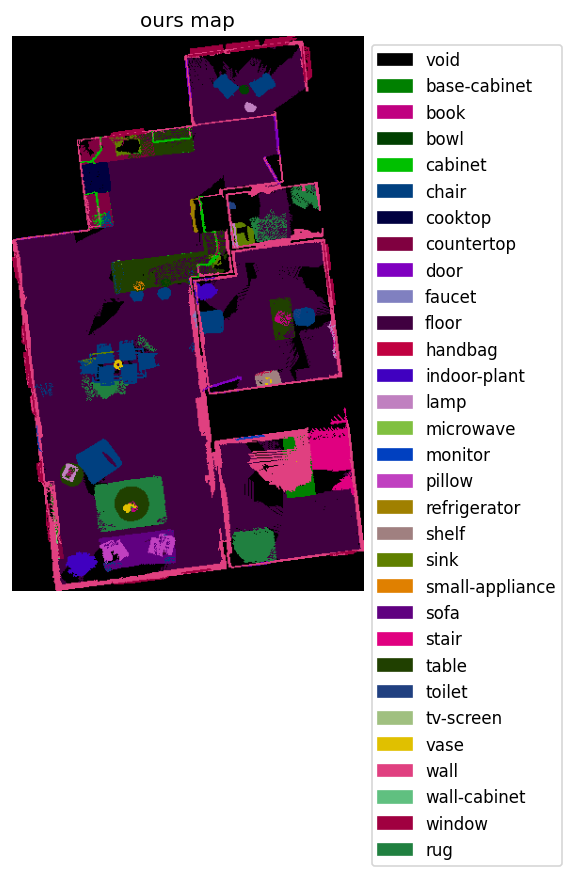

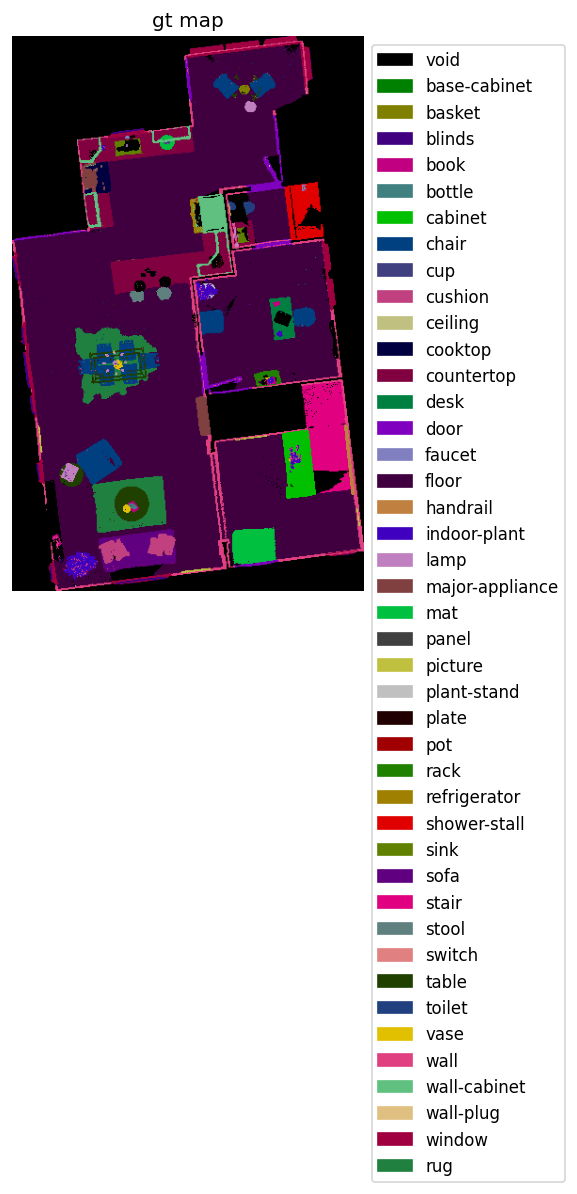

In [8]:
# new_categories = list(replica_cat.values())
if not use_hm3d:
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    from map.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
    new_pallete = get_new_pallete(len(new_categories))
    # print(len(new_pallete))
    mask, patches = get_new_mask_pallete(index_map.idx_map, new_pallete, out_label_flag=True, labels=new_categories)
    seg = mask.convert("RGBA")
    seg = np.array(seg)
    seg = Image.fromarray(seg)
    plt.figure(figsize=(10, 6), dpi=120)
    plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
    plt.axis('off')
    plt.title(f"{vln} map")
    plt.imshow(seg)
    plt.savefig(os.path.join(data_dir, "map", f"{version}_map.png"), bbox_inches='tight', pad_inches=0.1)
    plt.show()



    mask, patches = get_new_mask_pallete(gt_map, new_pallete, out_label_flag=True, labels=new_categories)
    seg = mask.convert("RGBA")
    seg = np.array(seg)
    seg = Image.fromarray(seg)
    plt.figure(figsize=(10, 6), dpi=120)
    plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
    plt.axis('off')
    plt.title(f"gt map")
    plt.imshow(seg)
    plt.savefig(os.path.join(data_dir, "map", f"gt_map.png"), bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [9]:
segmet = SegmentationMetric(index_map, gt_map, new_categories)#, ignore_list=[0,1,2])#[0,9,19,20,21])#[0,20,45,46,47])#, ignore_list=[0,1,2]) #0,20,45,46,47
top_k_auc, top_k_auc_mpacc, top_k_auc_fwmpacc, top_k_acc, top_k_mpacc, top_k_fwmpacc, k_spec_normalized, k_spec = segmet.cal_auc()
pacc, mpacc, miou, fwmiou = segmet.cal_ori()
# print(index_map.matching_cos.shape)
# print(top_k_auc)
print(top_k_acc)
print(pacc, mpacc, miou, fwmiou, top_k_auc)
print(top_k_auc, top_k_auc_mpacc, top_k_auc_fwmpacc)

[0.8358202  0.         0.         0.         0.07909604 0.
 0.         0.         0.7350808  0.         0.         0.
 0.5476992  0.20186204 0.         0.23687351 0.         0.84013355
 0.         0.         0.61494255 0.46622735 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.6425121  0.         0.
 0.29585007 0.         0.80062467 0.44951922 0.         0.
 0.17911124 0.2184466  0.         0.5851064  0.25028938 0.
 0.         0.5485085  0.39935568]
[0.0, 0.8158524426719841, 0.8473126076316505, 0.8616106226774223, 0.8628523520348047, 0.8654536390827517, 0.8676787818363092, 0.8689341067705973, 0.8707287229221427, 0.8821671349587601, 0.8823121544457536, 0.8825840659838666, 0.8831596120728723, 0.8889649234115834, 0.8891552614882625, 0.8956720746850358, 0.8962340251971359, 0.8965829783377142, 0.8967008066708964, 0.8967415934016133, 0.8977748572464425, 0.9021481011510922, 0.9028188162784374, 0.9036708057645246, 0.9041058642255053,

In [10]:
segmet = SegmentationMetric(index_map, gt_map, new_categories, ignore_list=[0,33,74,75,76])#[0,40,93,94,95])#[0,1,2])
top_k_auc, top_k_auc_mpacc, top_k_auc_fwmpacc, top_k_acc, top_k_mpacc, top_k_fwmpacc, k_spec_normalized, k_spec = segmet.cal_auc()
pacc, mpacc, miou, fwmiou = segmet.cal_ori()
# print(index_map.matching_cos.shape)
# print(top_k_auc)
print(top_k_acc)
print(pacc, mpacc, miou, fwmiou, top_k_auc)
print(top_k_auc, top_k_auc_mpacc, top_k_auc_fwmpacc)

[0.         0.         0.         0.07909604 0.         0.
 0.         0.7350808  0.         0.         0.         0.5476992
 0.         0.23687351 0.         0.84013355 0.         0.
 0.61494255 0.46622735 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.6425121  0.         0.         0.44951922 0.
 0.         0.17911124 0.2184466  0.         0.5851064  0.25028938
 0.         0.         0.5485085  0.39935568]
[0.0, 0.7594271410639438, 0.7911824941825896, 0.8059517430209426, 0.8077281636068678, 0.8119416570627399, 0.815222896740048, 0.8169626144213054, 0.819869484471001, 0.8371638931505039, 0.8373987917403783, 0.8378172048535921, 0.8379640164722636, 0.839564263115783, 0.8396229877632516, 0.8501787431457326, 0.8510742940196288, 0.8514927071328425, 0.8515147288756432, 0.8515807941040454, 0.8532397653950333, 0.8535333886323764, 0.8545170264774754, 0.8549354395906892, 0.8556401353603125, 0.8556841788459139, 0.8558089687217847, 0.8

In [11]:
segmet = SegmentationMetric(index_map, gt_map, new_categories, ignore_list=[0,33])#[0,40])#[0,1,2])
top_k_auc, top_k_auc_mpacc, top_k_auc_fwmpacc, top_k_acc, top_k_mpacc, top_k_fwmpacc, k_spec_normalized, k_spec = segmet.cal_auc()
pacc, mpacc, miou, fwmiou = segmet.cal_ori()
# print(index_map.matching_cos.shape)
# print(top_k_auc)
print(top_k_acc)
print(pacc, mpacc, miou, fwmiou, top_k_auc)
print(top_k_auc, top_k_auc_mpacc, top_k_auc_fwmpacc)
print(top_k_fwmpacc)

[0.         0.         0.         0.07909604 0.         0.
 0.         0.7350808  0.         0.         0.         0.5476992
 0.         0.23687351 0.         0.84013355 0.         0.
 0.61494255 0.46622735 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.6425121  0.         0.         0.29585007 0.
 0.80062467 0.44951922 0.         0.         0.17911124 0.2184466
 0.         0.5851064  0.25028938 0.         0.         0.5485085
 0.39935568]
[0.0, 0.7606086893660088, 0.7924166847393913, 0.8070555917010048, 0.8088050314465409, 0.8129545290247958, 0.8162365358201402, 0.8181377864526856, 0.82100050603629, 0.8380322417407648, 0.8382635726162077, 0.83867563073809, 0.8388202125352419, 0.8403961541241958, 0.8404539868430565, 0.8508494180582664, 0.851731367020892, 0.8521434251427745, 0.8521651124123473, 0.8522301742210656, 0.8538784067085954, 0.8541675703028989, 0.8551362683438155, 0.855548326465698, 0.8562423190920263, 0.856285693631

In [12]:
stop

NameError: name 'stop' is not defined

In [13]:
print(f"gt: {gt_map.shape}, pred: {ind_map.shape}")

# Initialize IoU metric calculator
iou_metric = IoU(num_classes=len(mp3dcat)+1)#, ignore_index=[1,2])#[0,1,2])

# Add the predicted and target data to the metric calculator
iou_metric.add(ind_map,gt_map)

# Compute and print the metrics
iou, miou, acc, fwiou, mf1, recalls, recall, precisions, precision = iou_metric.value()
print(f"IoU per class: {iou}")
print(f"Mean IoU: {miou}")
print(f"Accuracy: {acc}")
print(f"Fwiou: {fwiou}")
print(f"Mean F1: {mf1}")
print(f"Mean Recall: {recall}")
print(f"Mean Precision: {precision}")
print(f"Recall per class: {recalls}")
print(f"Precision per class: {precisions}")

NameError: name 'ind_map' is not defined

In [7]:
print(f"gt: {gt_map.shape}, pred: {ind_map.shape}")

# Initialize IoU metric calculator
iou_metric = IoU(num_classes=len(mp3dcat)+1, ignore_index=[])

# Add the predicted and target data to the metric calculator
iou_metric.add(ind_map,gt_map)

# Compute and print the metrics
iou, miou, acc, fwiou, mf1, recalls, recall, precisions, precision = iou_metric.value()
print(f"IoU per class: {iou}")
print(f"Mean IoU: {miou}")
print(f"Accuracy: {acc}")
print(f"Fwiou: {fwiou}")
print(f"Mean F1: {mf1}")
print(f"Mean Recall: {recall}")
print(f"Mean Precision: {precision}")
print(f"Recall per class: {recalls}")
print(f"Precision per class: {precisions}")

gt: (590, 374), pred: (590, 374)
49 0 51
<class 'numpy.ndarray'>
(51, 51)
IoU per class: [0.86223506 0.         0.                nan        nan 0.
 0.         0.         0.         0.67954687        nan 0.
 0.                nan 0.         0.72956909 0.05421076 0.
 0.11285794 0.         0.80153246 0.         0.60537022 0.12953876
 0.         0.                nan 0.         0.         0.
 0.         0.         0.         0.         0.58293839 0.
 0.09007418 0.80311891 0.44131691 0.         0.         0.17770184
 0.         0.                nan 0.16895413 0.         0.
 0.47786177 0.41950086        nan]
Mean IoU: 0.1621892760535553
Accuracy: 0.7849995468141031
Fwiou: 0.7048748939987908
Mean F1: 0.5619683641954099
Mean Recall: 0.24166365318727542
Mean Precision: 0.4369005100603983
Recall per class: [0.96430415 0.         0.                nan        nan 0.
 0.         0.         0.         0.92306071        nan 0.
 0.                nan 0.         0.94970986 0.05495959 0.
 0.12137681 0

In [8]:
print(len(mp3dcat)+1)

51


In [9]:
MPA=[]
MIOU=[]
F1=[]
aa=[]
FWIOU=[]

#! all index used
mask = (gt_map == ind_map)
pa = np.sum(mask) / mask.size

#! ignore index 0~3
# valid_mask = (gt > 2) & (predicts > 2)  # a와 b 모두 3 이상인 위치만 고려
# comparison_mask = (gt == predicts) & valid_mask  # 유효한 위치에서 값이 동일한 경우 True

# # 유효한 위치에 대한 Pixel Accuracy (PA) 계산
# pa = np.sum(comparison_mask) / np.sum(valid_mask)




for i in range(len(mp3dcat)):
    # if i<3: continue
    if i < 3 : continue
    m1 = (gt_map==i)
    m2 = (ind_map==i)
    # if np.sum(m1)==0: continue
    # if np.sum(m1)<100: continue
    mpa_i=np.sum(np.logical_and(m1,m2))/np.sum(m1)
    miou_i=np.sum(np.logical_and(m1,m2))/np.sum(np.logical_or(m1,m2))
    fwiou_i=np.sum(m1)*miou_i
    f1_i=2*np.sum(np.logical_and(m1,m2))/(np.sum(np.logical_or(m1,m2))+np.sum(np.logical_and(m1,m2)))
    MPA.append(mpa_i)
    MIOU.append(miou_i)
    F1.append(f1_i)
    aa.append(np.sum(m1))
    FWIOU.append(fwiou_i)

/tmp/ipykernel_334583/2322478573.py:28: RuntimeWarning: invalid value encountered in long_scalars
  mpa_i=np.sum(np.logical_and(m1,m2))/np.sum(m1)
/tmp/ipykernel_334583/2322478573.py:29: RuntimeWarning: invalid value encountered in long_scalars
  miou_i=np.sum(np.logical_and(m1,m2))/np.sum(np.logical_or(m1,m2))
/tmp/ipykernel_334583/2322478573.py:31: RuntimeWarning: invalid value encountered in long_scalars
  f1_i=2*np.sum(np.logical_and(m1,m2))/(np.sum(np.logical_or(m1,m2))+np.sum(np.logical_and(m1,m2)))


In [10]:
mpa=np.nanmean(MPA)
miou=np.nanmean(MIOU)
f1=np.nanmean(F1)
fwiou=np.nansum(FWIOU)/np.nansum(aa)

print("####")
print(np.sum(aa))
print(mask.size)


print(len(MPA),len(MIOU),len(F1),len(aa))
# print(mpa,miou,f1,fwiou)
print(f"pa : {pa}")
print(f"mpa : {mpa}")
print(f"miou : {miou}")
print(f"f1 : {f1}")
print(f"fwiou : {fwiou}")
print(f"aa : {np.sum(aa)}")
print(f"mask_size : {mask.size}")
print("##########################################")
print(pa)
print(MPA)
print(MIOU)
print(F1)
print(aa)
print(np.sum(aa))

####
145001
220660
47 47 47 47
pa : 0.7849995468141031
mpa : 0.2356808234439407
miou : 0.1530266607395187
f1 : 0.19671883184921188
fwiou : 0.6233855245892141
aa : 145001
mask_size : 220660
##########################################
0.7849995468141031
[nan, nan, 0.0, 0.0, 0.0, 0.0, 0.9230607082630692, nan, 0.0, 0.0, nan, 0.0, 0.9497098646034816, 0.054959588537839825, 0.0, 0.1213768115942029, 0.0, 0.8259611409673419, 0.0, 0.7294117647058823, 0.2888402625820569, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.6542553191489362, 0.0, 0.7634730538922155, 0.927405740011255, 0.44864588656106286, 0.0, 0.0, 0.6456285566476979, 0.0, 0.0, nan, 0.8092365300603287, 0.0, 0.0, 0.6408399710354815, 0.6444277391467769]
[nan, nan, 0.0, 0.0, 0.0, 0.0, 0.6795468653010552, nan, 0.0, 0.0, nan, 0.0, 0.7295690936106983, 0.054210755181910424, 0.0, 0.1128579449747333, 0.0, 0.8015324594570199, 0.0, 0.6053702196908055, 0.1295387634936212, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5829383886255924, 0.0